In [5]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os
import scipy
import corner
from astropy.cosmology import Planck15
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

# Colors
from palettable.colorbrewer.qualitative import Dark2_7
from palettable.colorbrewer.qualitative import Set1_7
from palettable.tableau import Tableau_10
col = Dark2_7.hex_colors
col2 = Tableau_10.hex_colors
col = Set1_7.hex_colors

from palettable.cubehelix import cubehelix3_16
cubehelix = cubehelix3_16.hex_colors

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

# Linking Lya velocity offset to bubble size

If only Lya with a given velocity offset can escape IGM with high transmission, can we infer minimum bubble size?

# Cosmology etc

In [135]:
def n_H(z):
    """
    IGM neutral hydrogen density
    """
    return 8.5e-5 * ((1. + z)/8.)**3. / (u.cm**3.)

def dt_dz(z):
    return 1. / ((1. + z) * Planck15.H(z))

# Estimate neutral fraction in a bubble

Use [Cen & Haiman (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJ...542L..75C/abstract), [Haiman (2004)](https://ui.adsabs.harvard.edu/abs/2002ApJ...576L...1H/abstract), [Mesinger, Haiman & Cen (2004)](https://ui.adsabs.harvard.edu/abs/2004ApJ...613...23M/abstract)

In [136]:
def x_HI_bubble(z, z_s=7., C_HII=3., Ndot_ion=1.e57/u.s):
    """
    Neutral fraction in a HII region as a function of distance from it
    
    TODO: assumes quasar ionizing spectrum
    """
    
    # Distance from source
    r = (z_s - z)*(const.c / Planck15.H(z=z_s)).to(u.Mpc)
    
    # Neutral fraction
    xHI = 1e-6 * C_HII * (r/1/u.Mpc)**2. * (Ndot_ion/1.e57*u.s)**-1. * ((1.+z)/8.)**3.
    
    xHI[xHI > 1.] = 1.
    
    return xHI

def R_bubble_CenHaiman2000(z_s, Ndot_ion=2.e57/u.s, t_Q=1e7*u.year):
    R_bubble = (0.75*Ndot_ion*t_Q/np.pi/n_H(z_s))**(1./3.)
    return (R_bubble).to(u.Mpc)

def z_bubble(R_bubble, z_s=7.):
    R_H = (const.c / Planck15.H(z=z_s)).to(u.Mpc)
    return z_s - R_bubble/R_H

Text(0, 0.5, 'Neutral fraction $x_\\mathrm{HI}$')

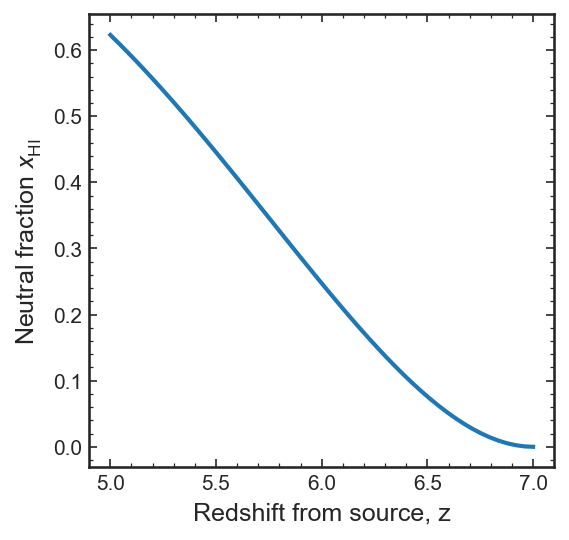

In [137]:
z_tab = np.linspace(5., 7.)

plt.plot(z_tab, x_HI_bubble(z_tab, z_s=z_tab.max()))
plt.xlabel('Redshift from source, z')
plt.ylabel('Neutral fraction $x_\mathrm{HI}$')

Text(0, 0.5, 'Bubble boundary, $z_s - z_b$')

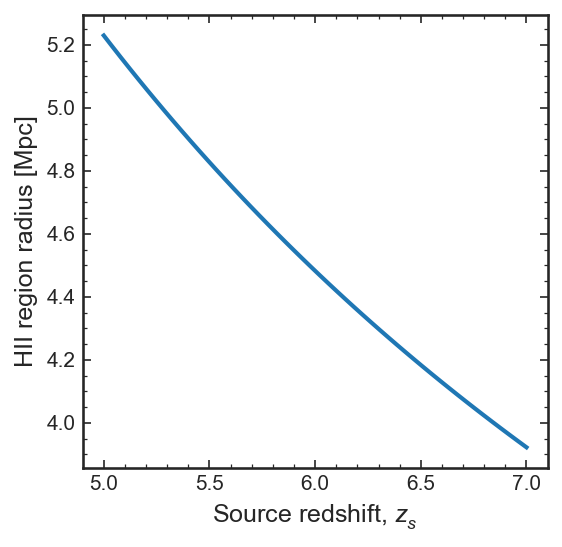

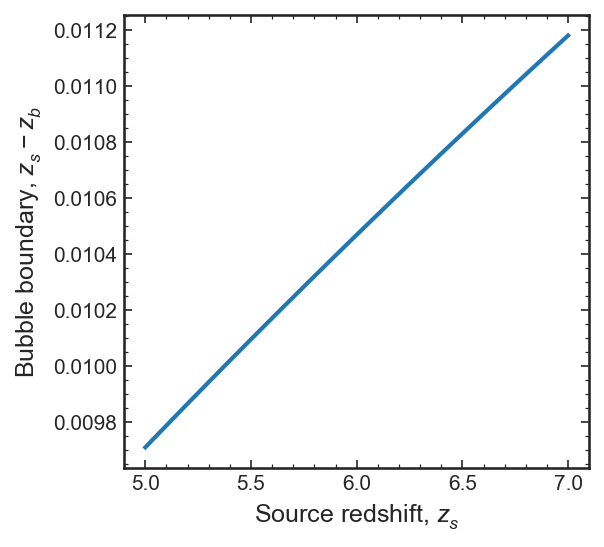

In [138]:
# Radius of HII region as a function of z
plt.figure()
plt.plot(z_tab, R_bubble_CenHaiman2000(z_s=z_tab))
plt.xlabel('Source redshift, $z_s$')
plt.ylabel('HII region radius [Mpc]')

plt.figure()
plt.plot(z_tab, z_tab - z_bubble(R_bubble_CenHaiman2000(z_s=z_tab), z_s=z_tab))
plt.xlabel('Source redshift, $z_s$')
plt.ylabel('Bubble boundary, $z_s - z_b$')

# Lya cross-section

This looks fine

In [139]:
wave_Lya = 1216. * u.Angstrom
freq_Lya = (const.c / wave_Lya).to(u.Hz)

def av(T):
    try:
        T = T.value
    except:
        pass
    return 4.7e-4 * (T/1.e4)**-0.5

def Voigt(x, T=1.e4):    
    phix = np.exp(-x**2.) + av(T)/np.sqrt(np.pi)/x**2.
    phix[phix > 1.] = 1.
    return phix

def v_thermal(T=1.e4*u.K):
    return (1./np.sqrt(const.m_p/2./const.k_B/T)).to(u.km/u.s)

def Lya_wave_to_x(wave, T=1.e4*u.K):
    freq = (const.c / wave).to(u.Hz)
    
    v_therm   = v_thermal(T)
    dfreq_Lya = (freq_Lya * v_therm / const.c).to(u.Hz)
    
    # Dimensionless frequency
    x = (freq - freq_Lya)/dfreq_Lya
    
    return x

def Lya_crosssec(wave, T=1.e4*u.K, returnx=False):
    
    x = Lya_wave_to_x(wave, T)
    
    sig_Lya0 = 5.9e-14 * (T/1.e4/u.K)**-0.5
    sig_Lya  = sig_Lya0 * Voigt(x, T) * u.cm**2.
    
    if returnx:
        return x, sig_Lya
    else:
        return sig_Lya

Text(0, 0.5, 'Lya cross-section [cm$^2$]')

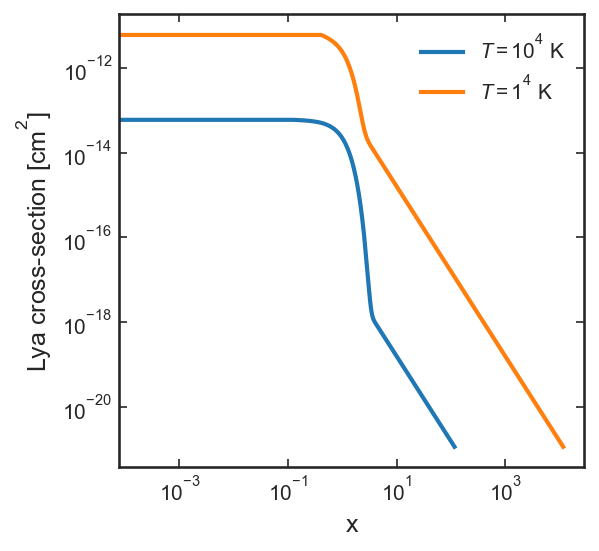

In [140]:
deltaL = 0.1
wavetab_fine = np.linspace(1216.-deltaL, 1216.+deltaL, 10000)
wavetab_all  = np.linspace(1210., 1222, 10000)
wavetab      = np.sort(np.concatenate((wavetab_fine, wavetab_all)))*u.Angstrom

# wavetab  = np.logspace(np.log10(1210.), np.log10(1222), 100000)*u.Angstrom
xtab = Lya_wave_to_x(wavetab, T=1e4*u.K)

plt.loglog(Lya_wave_to_x(wavetab, T=1e4*u.K), Lya_crosssec(wave=wavetab, T=1e4*u.K), label='$T = 10^4$ K')
plt.loglog(Lya_wave_to_x(wavetab, T=1*u.K), Lya_crosssec(wave=wavetab, T=1.*u.K), label='$T = 1^4$ K')

plt.legend()
plt.xlabel('x')
plt.ylabel('Lya cross-section [cm$^2$]')

# Optical depth

$$ \tau(\lambda_{obs, z_s}) = \int_{z_0}^{z_s} \, dz \; c \frac{dt}{dz} n_H(z) \sigma_\alpha(\lambda_{obs}/(1+z)) $$

Neutral hydrogen density depends on HI fraction, calculate this inside the HII regions:

$$ n_H(z) = n_{H,0}(z) x_{HI}$$

In [146]:
def optical_depth(wave_em, T, z_min, z_max, z_s=7.,
                  inside_HII=True, C_HII=3., Ndot_ion=1.e57/u.s):
    """
    Lya optical depth as a function of wavelength 
    using definition of optical depth and Lya cross-section
    """
    
    # Make redshift array for integration
    ztab = np.linspace(z_min, z_max, 1000)
    
    # Find observed Lya wavelength as a function of redshift
    wave_obs      = wave_em * (1. + z_s)
    wave_redshift = wave_obs / (1. + ztab)
    
    if inside_HII:
        xHI = x_HI_bubble(ztab, z_s=z_s, C_HII=C_HII, Ndot_ion=Ndot_ion)
    else:
        xHI = 1.
#         T   = 1.2 * ((1.+ztab)/8.)**-2. * u.K
    
    prefac = (const.c * dt_dz(ztab) * xHI * n_H(ztab)).to(1./u.cm**2.)
    dtau   = prefac * Lya_crosssec(wave_redshift, T)
        
    tau = np.trapz(dtau, ztab)
        
    del dtau
    
    return tau

f_a = 0.4164 # Oscillator strength from Draine sec. 9.7
squared_electron_charge_cgs = (const.e.esu**2.).to(u.cm**3. * u.g/ u.s**2.)

def optical_depth_damping_ME98(z, x_HI, z_s, z_HII, z_end):
    """
    Miralda-Escude 1998 approximation for the damping wing
    """
    
    prefac = 6.43e-9 * wave_Lya * x_HI * (np.pi * squared_electron_charge_cgs * f_a / const.m_e / const.c) * (n_H(z) / Planck15.H(z))
    
    tau = prefac.to(u.cm/u.cm) * (I((1.+z_HII)/(1.+z)) - I((1.+z_end)/(1.+z)))
    
    return tau

def optical_depth_damping_DW10(z_min, z_s=7.,
                               x_HI=1., R_HII=1*u.Mpc):
    """
    Eqn 104 in Dijkstra lecture notes
    """
    
    ztab = np.linspace(z_min, z_s, 1000)
    
    deltav = ((z_s - ztab)/(1 + z_s) * const.c).to(u.km/u.s)    
    deltav_HII = (deltav + Planck15.H(z_s)*R_HII/(1+z_s)).to(u.km/u.s)
    
    tau = 2.3 * x_HI * (600 * u.km/u.s / deltav_HII) * ((1. + z_s)/10.)**1.5
    
    return deltav, tau

    
def I(x):
    return x**4.5/(1.- x) + 9./7.*x**3.5 + 9./5.*x**2.5 + 3*x**1.5 + 9*x**0.5 - np.log(np.abs(((1+x**0.5)/(1-x**0.5))))

In [149]:
optical_depth_damping_ME98(z=ztab, x_HI=1., z_s=z_s, z_HII=z_ion[i], z_end=z_min)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in subtract


<Quantity [         nan, -15.16662159,  -7.58627779,  -5.05988939,
            -3.79689052,  -3.03920976,  -2.53416956,  -2.17348495,
            -1.90301608,  -1.69268673,  -1.52445204,  -1.38682945,
            -1.27216432,  -1.17515753,  -1.09202415,  -1.01998873,
            -0.95696976,  -0.9013756 ,  -0.85196833,  -0.80777071,
            -0.768001  ,  -0.73202637,  -0.69932908,  -0.66948146,
            -0.64212714,  -0.61696675,  -0.59374704,  -0.57225224,
            -0.55229745,  -0.53372326,  -0.51639153,  -0.50018194,
            -0.48498923,  -0.4707209 ,  -0.45729532,  -0.44464021,
            -0.43269132,  -0.42139135,  -0.41068903,  -0.40053835,
            -0.39089791,  -0.38173033,  -0.37300183,  -0.36468174,
            -0.35674219,  -0.3491578 ,  -0.34190537,  -0.3349637 ,
            -0.32831336,  -0.32193649,  -0.31581667,  -0.30993876,
            -0.30428879,  -0.29885386,  -0.293622  ,  -0.28858213,
            -0.28372394,  -0.27903788,  -0.27451503,  -0.27014

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in subtract
No handles with labels found to put in legend.


(-1000, 1000)

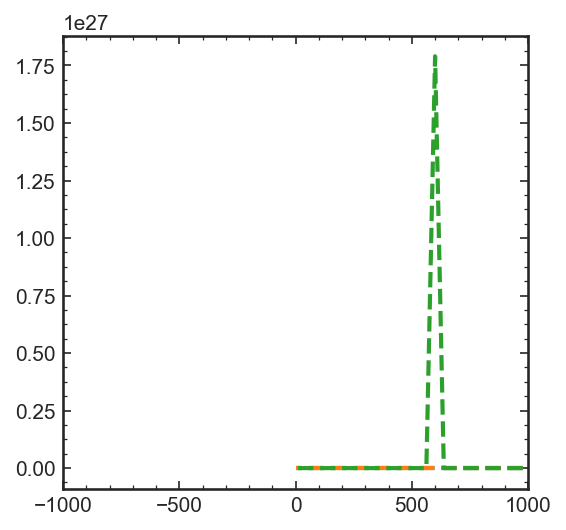

In [150]:
R_ion = np.linspace(0.5, 5.5, 3)*u.Mpc
z_ion = z_bubble(R_ion, z_s=z_s)

z_min = 6.
z_s   = 7.

for i, R_HII in enumerate(R_ion):
    deltav, tau = optical_depth_damping_DW10(z_min=z_min, z_s=z_s, R_HII=R_HII)

#     plt.plot(deltav, np.exp(-tau), label=R_HII)
    
    ztab = np.linspace(z_min, z_s, 1000)
    tau  = optical_depth_damping_ME98(z=ztab, x_HI=1., z_s=z_s, z_HII=z_ion[i], z_end=z_min)
    
    plt.plot(deltav, np.exp(-tau), ls='dashed')
    
plt.legend(loc='upper left')
plt.xlim(-1000, 1000)

In [44]:
optical_depth_damping(x_HI=1., z=7.)

<Quantity 218.074668>

In [103]:
z_s = 7.
R_ion = R_bubble_CenHaiman2000(z_s=z_s)
z_ion = z_bubble(R_ion, z_s=z_s)
z_min = 6.

print(R_ion, z_ion)

# inside bubble
tau_HII = optical_depth(wavetab[:,None], z_min=z_ion, z_max=z_s, z_s=z_s,
                        inside_HII=True, T=1.e4*u.K, Ndot_ion=2.e57/u.s)

# in IGM
tau_IGM = optical_depth(wavetab[:,None], z_min=z_min, z_max=z_ion, z_s=z_s,
                        inside_HII=False, T=1.*u.K, Ndot_ion=2.e57/u.s)

3.9221566084210626 Mpc 6.988818693831728


Text(0.5, 0, 'Velocity offset [km/s]')

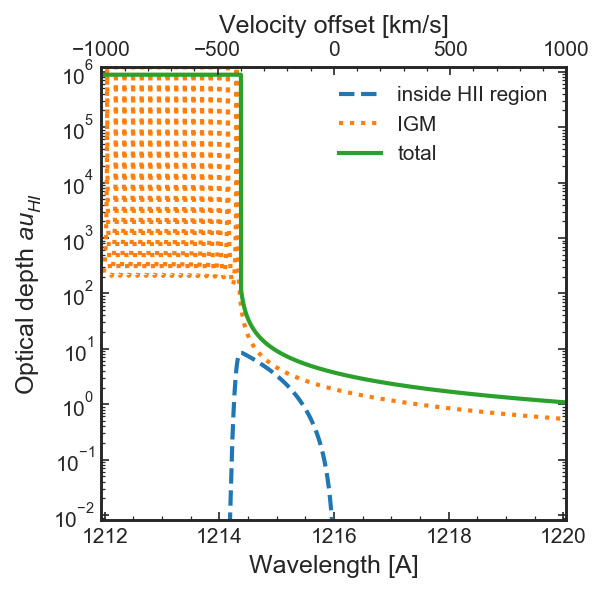

In [104]:
def wave_to_DV(wave):
    return ((wave - wave_Lya)*const.c/wave_Lya).to(u.km/u.s)

def DV_to_wave(DV):
    return wave_Lya + (DV/const.c * wave_Lya).to(u.Angstrom)

DV_tab = wave_to_DV(wavetab)

fig, ax_wave = plt.subplots(1,1)

ax_wave.semilogy(wavetab, tau_HII, ls='dashed', label='inside HII region')
ax_wave.semilogy(wavetab, tau_IGM, ls='dotted', label='IGM')

tau_total = tau_IGM + tau_IGM
tau_total[DV_tab.value < -400.] = np.mean(tau_total[DV_tab.value < -400.])

ax_wave.semilogy(wavetab, tau_total, label='total')

ax_DV = ax_wave.twiny()
ax_DV.semilogy(DV_tab, tau_total, label='total', lw=0)

ax_wave.legend()
ax_wave.set_ylim(0.8e-2, 1.2e6)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel('Optical depth $\tau_{HI}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')


# Change bubble size

[0.5 3.  5.5] Mpc [6.9985746  6.99144758 6.98432057]


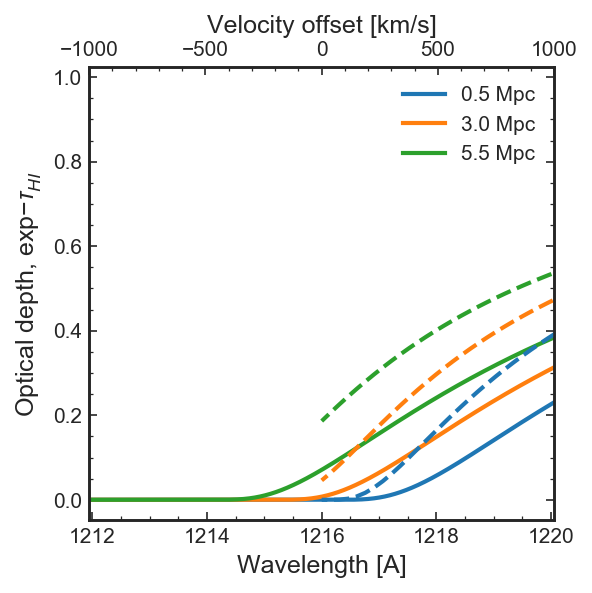

In [107]:
z_s = 7.
R_ion = np.linspace(0.5, 5.5, 3)*u.Mpc
z_ion = z_bubble(R_ion, z_s=z_s)
z_min = 6.

print(R_ion, z_ion)

fig, ax_wave = plt.subplots(1,1)
ax_DV = ax_wave.twiny()

for i, z_ion_i in enumerate(z_ion):
    # inside bubble
    tau_HII = optical_depth(wavetab[:,None], z_min=z_ion_i, z_max=z_s, z_s=z_s,
                            inside_HII=True, T=1.e4*u.K, Ndot_ion=2.e57/u.s)

    # in IGM
    tau_IGM = optical_depth(wavetab[:,None], z_min=z_min, z_max=z_ion_i, z_s=z_s,
                            inside_HII=False, T=1.*u.K, Ndot_ion=2.e57/u.s)
    
    tau_total = tau_IGM + tau_IGM
    tau_total[:np.argmax(tau_HII)] = np.mean(tau_total[:np.argmax(tau_HII)])

#     ax_wave.plot(wavetab, np.exp(-tau_HII), c=col2[i], alpha=0.5, lw=1, ls='dashed')
#     ax_wave.plot(wavetab, np.exp(-tau_IGM), c=col2[i], alpha=0.7, ls='dotted')

    trans = np.exp(-tau_total)
    
    ax_wave.plot(wavetab, trans, c=col2[i], label=R_ion[i])
    ax_DV.plot(DV_tab, trans, label='total', lw=0)
    
    # ME1998 approx
    deltav, tau = optical_depth_damping_DW10(z_min=z_min, z_s=z_s, R_HII=R_ion[i])
    ax_DV.plot(deltav, np.exp(-tau), ls='dashed', c=col2[i], label=R_ion[i])

    ax_wave.legend()
#     ax_wave.set_ylim(0.8e-2, 1.2e6)
#     ax_wave.set_ylim(0., 1)
    ax_DV.set_xlim(-1000, 1000)
    ax_wave.set_xlim(DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

    ax_wave.set_ylabel(r'Optical depth, $\exp{-\tau_{HI}}$')
    ax_wave.set_xlabel('Wavelength [A]')
    ax_DV.set_xlabel('Velocity offset [km/s]')
    
plt.savefig('opticaldepth.pdf', bbox_inches='tight')

## Make a grid

In [316]:
R_ion = np.logspace(-2, 1., 20)*u.Mpc
print(R_ion)


[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ] Mpc


In [288]:
z_s = 7.
R_ion = np.logspace(-2, 1., 20)*u.Mpc
print(R_ion)

z_ion = z_bubble(R_ion, z_s=z_s)
z_min = 6.

print(R_ion)

trans_tot = np.zeros((len(R_ion),len(wavetab)))

for i, z_ion_i in enumerate(z_ion):
    
    print(R_ion[i], z_ion[i])
    # inside bubble
    tau_HII = optical_depth(wavetab[:,None], z_min=z_ion_i, z_max=z_s, z_s=z_s,
                            inside_HII=True, T=1.e4*u.K, Ndot_ion=2.e57/u.s)

    # in IGM
    tau_IGM = optical_depth(wavetab[:,None], z_min=z_min, z_max=z_ion_i, z_s=z_s,
                            inside_HII=False, T=1.*u.K, Ndot_ion=2.e57/u.s)
    
    tau_total = tau_IGM + tau_IGM
    tau_total[:np.argmax(tau_HII)] = np.mean(tau_total[:np.argmax(tau_HII)])

    trans_tot[i] = np.exp(-tau_total)

[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ] Mpc
[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ] Mpc
0.01 Mpc 6.99997149194363
0.01438449888287663 Mpc 6.9999589925895
0.0206913808111479 Mpc 6.999941012894947
0.029763514416313176 Mpc 6.999915150005327
0.04281332398719394 Mpc 6.999877947534641
0.06158482110660264 Mpc 6.999824433644839
0.08858667904100823 Mpc 6.999747456596031
0.12742749857031335 Mpc 6.999636728968774
0.18329807108324356 Mpc 6.999477452825714
0.26366508987303583 Mpc 6.999248342075524
0.37926901907322497 Mpc 6.9989187777425075
0.5455594781168517 Mpc 6.998444715964495
0.78475997035146

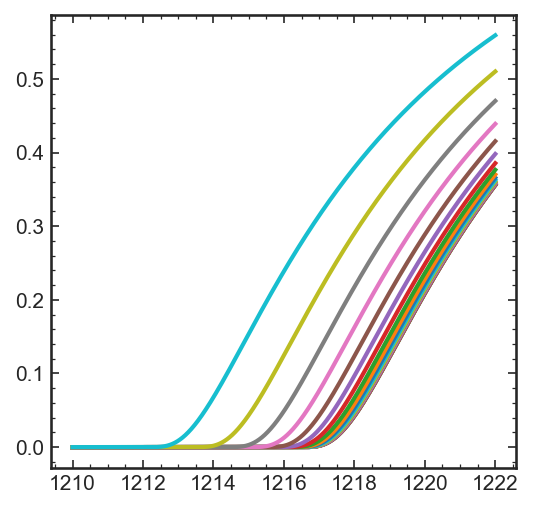

In [289]:
plt.plot(wavetab, trans_tot.T)
plt.show()

# Change ionizing photon output of source 

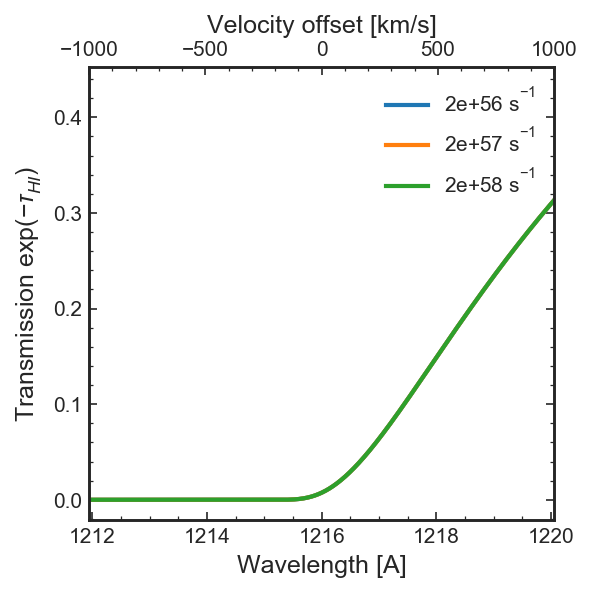

In [163]:
z_s = 7.
R_ion = 3.*u.Mpc
z_ion = z_bubble(R_ion, z_s=z_s)
z_min = 6.

fig, ax_wave = plt.subplots(1,1)
ax_DV = ax_wave.twiny()

Ndot_ion_tab = np.logspace(-1., 1., 3)*2.e57/u.s

for i, Ndot_ion in enumerate(Ndot_ion_tab):
    # inside bubble
    tau_HII = optical_depth(wavetab[:,None], z_min=z_ion, z_max=z_s, z_s=z_s,
                            inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

    # in IGM
    tau_IGM = optical_depth(wavetab[:,None], z_min=z_min, z_max=z_ion, z_s=z_s,
                            inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)
    
    tau_total = tau_IGM + tau_IGM
    tau_total[:np.argmax(tau_HII)] = np.mean(tau_total[:np.argmax(tau_HII)])

#     ax_wave.semilogy(wavetab, tau_HII, c=col2[i], alpha=0.5, lw=1, ls='dashed')
#     ax_wave.plot(wavetab, tau_IGM, c=col2[i], alpha=0.7, ls='dotted')

    trans_tot = np.exp(-tau_total)
    
    ax_wave.plot(wavetab, trans_tot, c=col2[i], label='%.0e s$^{-1}$' % Ndot_ion.value)

    ax_DV.plot(DV_tab, trans_tot, label='total', lw=0)

    ax_wave.legend()
#     ax_wave.set_ylim(0.8e-2, 1.2e6)
#     ax_wave.set_ylim(0., 1)
    ax_DV.set_xlim(-1000, 1000)
    ax_wave.set_xlim(DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

    ax_wave.set_ylabel(r'Transmission, $\exp(-\tau_{HI})$')
    ax_wave.set_xlabel('Wavelength [A]')
    ax_DV.set_xlabel('Velocity offset [km/s]')
    

# Add fake lines

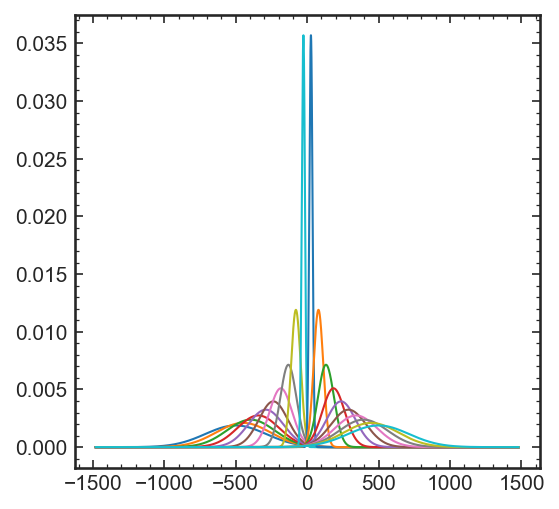

In [311]:
line_DV = np.linspace(-500., 500, 20)

velocity = wave_to_DV(wavetab).value

lines = np.array([reionizer.line_shape_gauss(v=velocity, vcenter=DV, fwhm=DV, vmin=-2000.) for DV in line_DV])

plt.plot(velocity, lines.T, lw=1)
plt.show()

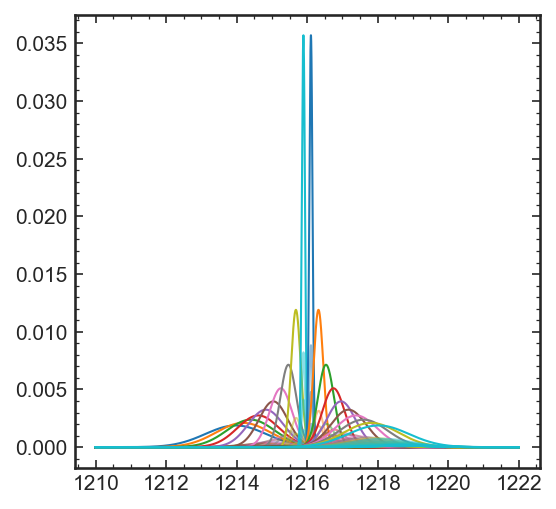

In [317]:
Tigm = np.zeros((len(lines), len(trans_tot)))

for i, line in enumerate(lines):
    ln = plt.plot(wavetab, line, lw=1, alpha=1)
    plt.plot(wavetab, (line*trans_tot).T, c=ln[0].get_color(), lw=1, alpha=0.5)
    
    Tigm[i] = np.trapz(line*trans_tot, velocity)

In [318]:
print(R_ion.value)

[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]


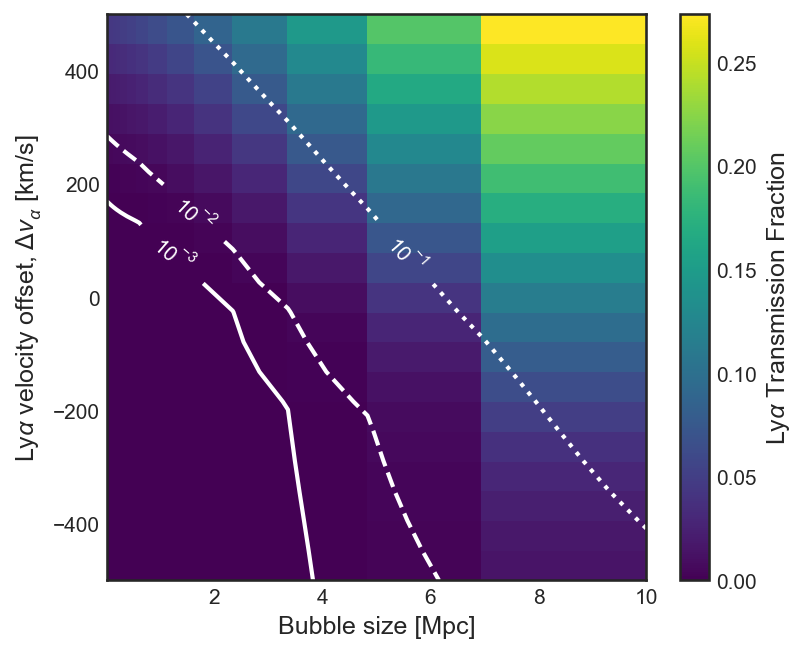

In [319]:
# reionizer.plot_image(Tigm, R_ion.value, line_DV,
#                      xlabel='Bubble size [Mpc]', 
#                      ylabel=r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]', 
#                      cmap='viridis', clabel=r'Ly$\alpha$ Transmission Fraction')

plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(R_ion.value, line_DV, Tigm, cmap='viridis')
plt.colorbar(im, label=r'Ly$\alpha$ Transmission Fraction')

Tigm_levels = [0.001, 0.01, 0.1]
cs = plt.contour(R_ion.value, line_DV, Tigm, levels=Tigm_levels, 
                 colors='w', linestyles=['solid', 'dashed', 'dotted'])

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, fmt=fmt, inline_spacing=20.)

plt.xlabel('Bubble size [Mpc]')
plt.ylabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav.pdf', bbox_inches='tight')

Text(0, 0.5, 'Lya transmission')

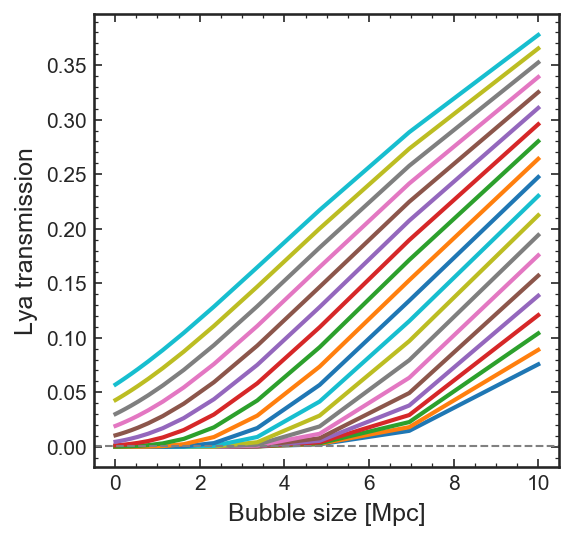

In [320]:
for i, line in enumerate(lines):
    plt.plot(R_ion, Tigm[i])
plt.axhline(1e-3, c='0.5', ls='dashed', lw=1)
plt.xlabel('Bubble size [Mpc]')
plt.ylabel('Lya transmission')

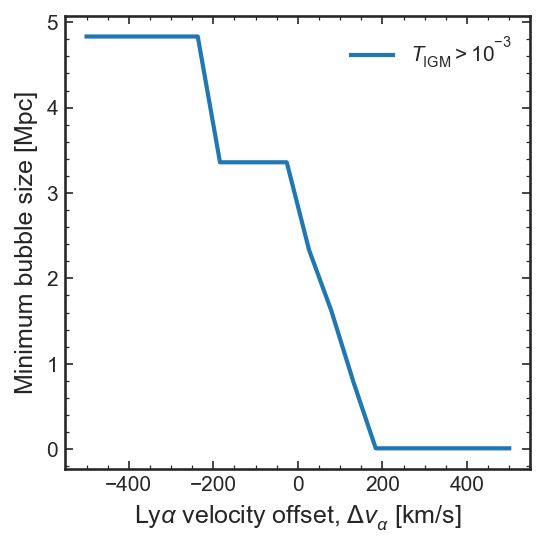

In [321]:
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion[np.where(Tigm[i] >= 1.e-3)[0][0]].value

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > 10^{-3}$')

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')